<a href="https://colab.research.google.com/github/suneel87/Deep-Fake-Image-Detection/blob/main/DeepFake_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install streamlit

### **Import Necessary Modules**

In [3]:
from itertools import permutations, product
from random import sample, choice, shuffle
from glob import glob
import time
from datetime import timedelta
from tqdm import tqdm


%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models
import streamlit as st

### **Functions Used**

In [4]:
'''
This functions computes the Contrastive loss for a CFFN

Input: Label(y)(0 or 1), Feature Vectors for a pair of images(fx1,fx2)
Output: The value of Contrastive loss
Return Type: PyTorch Tensor
'''
def ContrastiveLoss(y,fx1,fx2):
  m=2
  E=torch.pow((fx1-fx2),2)
  mat_max = np.maximum(np.zeros((y.shape[0], 128)), torch.pow((m-E),2).detach().cpu().numpy())
  torch_loss = 0.5*(y.detach().cpu().numpy()*torch.pow(E,2).detach().cpu().numpy().T) + (1-y.detach().cpu().numpy())*mat_max.T
  return torch.tensor(torch.sum(torch.tensor(torch_loss.T)), requires_grad=True)

In [5]:
'''
This functions plots multiple images in one grid

Input: A grid of images made using torch.utils
Output: The plot (matplotlib) for these images in one grid
'''
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

In [6]:
'''
This functions plots the loss for that particular iteration in an epoch

Input: Iteration Number (iteration) and the Loss (loss)
Output: The matplotlib plot for the loss
'''
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [7]:
'''
This functions predicts the state of a given image

Input: The image (image)
Output: The value of the state of the image (0 for fake and 1 for real)
Return Type: Integer
'''
def predict_image(image):

    net = SiameseNetwork(models.resnet50(pretrained=True),1000).cuda()
    net2 = NeuralNet().cuda()

    net.load_state_dict(torch.load("net.pth"))
    net2.load_state_dict(torch.load("net2.pth"))

    net.eval()
    net2.eval()
    test_transforms = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
    img=Image.open(image)
    image_tensor = test_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.cuda()
    out1=net([input])
    output = net2(out1[0])
    print(output.data.cpu().numpy())
    index = output.data.cpu().numpy().argmax()
    
    return index

### **Reading the images and pairing them**

In [8]:
fake = glob("/content/drive/My Drive/faces/fake/*")
real = glob("/content/drive/My Drive/faces/real/*")

In [9]:
fake_ = [x.split("/")[-1] for x in fake]
real_ = [x.split("/")[-1] for x in real]

fake_ = ["fake_" + x for x in fake_]

In [10]:
start = time.time()

pairs_distinct = list(product(real_,fake_))

pairs_real = list(product(real_,real_))

pairs_fake = list(product(fake_,fake_))

end = time.time()

print(f'Time Taken: {timedelta(seconds=(end - start))}')

Time Taken: 0:00:00.325161


In [11]:
len(pairs_distinct) + len(pairs_fake) + len(pairs_real)

3127921

In [12]:
pairs = pairs_distinct + pairs_real + pairs_fake
pairs = sample(pairs, len(pairs))
pairs = list(set(pairs))

In [13]:
ord('f'), ord('r')

(102, 114)

In [14]:
start = time.time()

label_dict = {}
for idx, pair in enumerate(pairs):
    l1, l2 = pair[0].split("_")[0][0], pair[1].split("_")[0][0]
    
    l_sum = ord(l1) + ord(l2)
    
    if l_sum == 204:
        label = 1 #impostor pair
    elif l_sum == 216:
        label = 0
    elif l_sum == 228:
        label = 1 # real pair
    
    label_dict[idx] = label

end = time.time()

print(f'Time Taken: {timedelta(seconds=(end - start))}')

Time Taken: 0:00:04.738180


### **Forming a Dataset**

In [15]:
BATCH_SIZE=64
NUMBER_EPOCHS=30
IMG_SIZE=100

In [25]:
import sklearn.model_selection
import pandas as pd

In [22]:
train_per = .70
test_per = .15
val_per = .15
total_len = len(pairs)

a, b = sklearn.model_selection.train_test_split(pairs, train_size=train_per, test_size=test_per + val_per)
b, c = sklearn.model_selection.train_test_split(b, train_size=test_per, test_size=val_per)

In [23]:
len(a), len(b), len(c)

(2189544, 140756, 140757)

In [24]:
class DFDataset(Dataset):
    
    def __init__(self, root_dir, real_dir, fake_dir, pairs, lab_dict, transform=None):
        self.root_dir = root_dir
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        self.pairs = pairs
        self.lab_dict = lab_dict
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        class_labels = []
        
        if pair[0].split("_")[0] == "real":
            img1 = Image.open(f'{self.root_dir}/{self.real_dir}/{pair[0]}')
            class_labels.append(1)
            
        elif pair[0].split("_")[0] == "fake":
            path_ = pair[0].replace('fake_', '')
            img1 = Image.open(f'{self.root_dir}/{self.fake_dir}/{path_}')
            class_labels.append(0)
            
        if pair[1].split("_")[0] == "real":
            img2 = Image.open(f'{self.root_dir}/{self.real_dir}/{pair[1]}')
            class_labels.append(1)
            
        elif pair[1].split("_")[0] == "fake":
            path_ = pair[1].replace('fake_', '')
            img2 = Image.open(f'{self.root_dir}/{self.fake_dir}/{path_}')
            class_labels.append(0)
            
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        
        label = self.lab_dict[idx]
        
        return img1, img2, label, class_labels
        

In [28]:
trainset = DFDataset('/content/drive/My Drive/faces', 'real', 'fake', sample(list(a), 10000), label_dict, 
                                                             transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

trainloader = DataLoader(trainset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        batch_size=BATCH_SIZE)


valset = DFDataset('/content/drive/My Drive/faces', 'real', 'fake', sample(list(c), 10000), label_dict, 
                                                             transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ]))

valloader = DataLoader(valset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        batch_size=BATCH_SIZE)


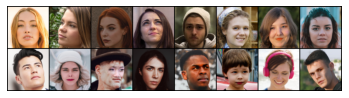

[0 1 0 0 1 1 1 1]


In [29]:
vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

### **Building a CFFN**

In [30]:
class SiameseNetwork(nn.Module):# A simple implementation of siamese network
    def __init__(self,model,n):#Parameters: The name of the model used and the size
        super(SiameseNetwork, self).__init__()
        self.cnn1 = model
        self.fc1 = nn.Linear(n, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 128)


    def forward(self, inputs):
        results = []

        for input in inputs:
            output = self.cnn1(input)
            output = output.view(output.size()[0], -1)
            output = F.relu(self.fc1(output))
            output = F.relu(self.fc2(output))
            output = self.fc3(output)

            results.append(output)

        return results

In [35]:
# custom_cnn =  nn.Sequential(
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(3, BATCH_SIZE, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(BATCH_SIZE),
#             nn.Dropout2d(p=.2),
            
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(BATCH_SIZE, BATCH_SIZE, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(BATCH_SIZE),
#             nn.Dropout2d(p=.2),

#             nn.ReflectionPad2d(1),
#             nn.Conv2d(BATCH_SIZE, 32, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(32),
#             nn.Dropout2d(p=.2),
#         )

# custom_cnn_n = 32*100*100

#models.resnet50(pretrained=True)

#models.alexnet(pretrained=True)

#models.densenet(pretrained=True)

#models.vgg16(pretrained=True)

#models.resnet50(pretrained=True)

#models.googlenet(pretrained=True)

net = SiameseNetwork(models.resnet50(pretrained=True),1000).cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels, _ = data
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        #print("epoch：", epoch, "No." , i, "th inputs", img0.data.size(), "labels", labels.data.size())
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net([img0,img1])
        loss = ContrastiveLoss(labels, outputs[0], outputs[1])
        loss.backward()
        optimizer.step()

        print("Iteration number {}\n Current loss {}\n".format(i,loss.item()))

Epoch： 0  start.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Iteration number 0
 Current loss 12743.440516352744

Iteration number 1
 Current loss 7835.824431966851

Iteration number 2
 Current loss 6875.379777787004

Iteration number 3
 Current loss 11217.582393531025

Iteration number 4
 Current loss 11812.208207827134

Iteration number 5
 Current loss 11757.16691088368

Iteration number 6
 Current loss 9322.967221226718

Iteration number 7
 Current loss 9308.899471428314

Iteration number 8
 Current loss 12225.869262998207

Iteration number 9
 Current loss 10775.772997985587

Iteration number 10
 Current loss 11252.531692580733

Iteration number 11
 Current loss 8803.474522922315

Iteration number 12
 Current loss 13244.634708974596

Iteration number 13
 Current loss 10809.386895963642

Iteration number 14
 Current loss 10282.794715732438

Iteration number 15
 Current loss 10292.186524021425

Iteration number 16
 Current loss 9841.168369754027

Iteration number 17
 Current loss 8838.612039089887

Iteration number 18
 Current loss 11322.707045

KeyboardInterrupt: ignored

### **Building a Classification Network**

In [32]:
class NeuralNet(nn.Module):
    
    def __init__(self, in_features=4, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features=128,
                             out_features=120)
        self.fc2 = nn.Linear(in_features=120, 
                             out_features=84)
        self.fc3 = nn.Linear(in_features=84,  
                             out_features=2)
        self.activation = nn.Softmax(dim=1)

        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        return self.activation(X)

Epoch： 0  start.
Iteration number 0
 Current loss 0.6926590800285339

Iteration number 1
 Current loss 0.6929457783699036

Iteration number 2
 Current loss 0.6924201846122742

Iteration number 3
 Current loss 0.6923823356628418

Iteration number 4
 Current loss 0.6926300525665283

Iteration number 5
 Current loss 0.6928725242614746

Iteration number 6
 Current loss 0.6925963163375854

Iteration number 7
 Current loss 0.6929397583007812

Iteration number 8
 Current loss 0.6924700140953064

Iteration number 9
 Current loss 0.6926077604293823

Iteration number 10
 Current loss 0.6927099823951721

Iteration number 11
 Current loss 0.6926326155662537

Iteration number 12
 Current loss 0.6927179098129272

Iteration number 13
 Current loss 0.6924678087234497

Iteration number 14
 Current loss 0.6931355595588684

Iteration number 15
 Current loss 0.692415714263916

Iteration number 16
 Current loss 0.6928896307945251

Iteration number 17
 Current loss 0.6925935745239258

Iteration number 18
 C

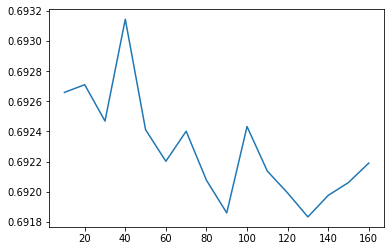

Epoch： 1  start.
Iteration number 0
 Current loss 0.6923592686653137

Iteration number 1
 Current loss 0.6906230449676514

Iteration number 2
 Current loss 0.6924300193786621

Iteration number 3
 Current loss 0.6917213201522827

Iteration number 4
 Current loss 0.6920926570892334

Iteration number 5
 Current loss 0.6925116777420044

Iteration number 6
 Current loss 0.6914910078048706

Iteration number 7
 Current loss 0.6922717690467834

Iteration number 8
 Current loss 0.6918754577636719

Iteration number 9
 Current loss 0.6908890604972839

Iteration number 10
 Current loss 0.6906982064247131

Iteration number 11
 Current loss 0.6915705800056458

Iteration number 12
 Current loss 0.6917259693145752

Iteration number 13
 Current loss 0.6913977265357971

Iteration number 14
 Current loss 0.691694974899292

Iteration number 15
 Current loss 0.6908840537071228

Iteration number 16
 Current loss 0.6917141079902649

Iteration number 17
 Current loss 0.6922916173934937

Iteration number 18
 C

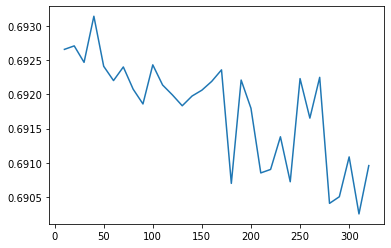

Epoch： 2  start.
Iteration number 0
 Current loss 0.6910426616668701

Iteration number 1
 Current loss 0.689932644367218

Iteration number 2
 Current loss 0.6919428110122681

Iteration number 3
 Current loss 0.6905553340911865

Iteration number 4
 Current loss 0.690067708492279

Iteration number 5
 Current loss 0.6893705725669861

Iteration number 6
 Current loss 0.6913541555404663

Iteration number 7
 Current loss 0.6913486123085022

Iteration number 8
 Current loss 0.6896065473556519

Iteration number 9
 Current loss 0.691714346408844

Iteration number 10
 Current loss 0.6913889646530151

Iteration number 11
 Current loss 0.6910547018051147

Iteration number 12
 Current loss 0.6898008584976196

Iteration number 13
 Current loss 0.6902993321418762

Iteration number 14
 Current loss 0.6901970505714417

Iteration number 15
 Current loss 0.6905050277709961

Iteration number 16
 Current loss 0.6918627619743347

Iteration number 17
 Current loss 0.6903783679008484

Iteration number 18
 Cur

KeyboardInterrupt: ignored

In [34]:
net2 = NeuralNet().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,5):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels, class_labels = data 
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net([img0,img1])
        out2 = net2(outputs[0])
        loss = criterion(out2, class_labels[0].cuda())

        loss.backward()
        optimizer.step()

        print("Iteration number {}\n Current loss {}\n".format(i,loss.item()))
        if i %10 == 0 :#show changes of loss value after each 10 batches
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())

        torch.save(net.state_dict(),"/content/drive/My Drive/saved_models/resnet-clf.pth")
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing
        for data in valloader:
            img0, img1 , labels, class_labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net([img0,img1])
            out = net2(outputs[0])
            _, predicted = torch.max(out.data, 1)
            total_val += class_labels[0].cuda().size(0)
            correct_val += (predicted == class_labels[0].cuda()).sum().item()
            
    print('Accuracy of the network on the', total_val,': %d %%' % (100 * correct_val / total_val))
    show_plot(counter,loss_history)

In [ ]:
torch.save(net.state_dict(),"/content/drive/My Drive/saved_models/resnet-cffn.pth")

### **Streamlit GUI**

In [ ]:
#Writing all necessary functions in one cell
%%writefile DeepFakeGUI.py
import streamlit as st

from itertools import permutations, product
from random import sample, choice, shuffle
from glob import glob
import time
from datetime import timedelta
from tqdm import tqdm
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models


class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
    def __init__(self,model,n):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = model
        self.fc1 = nn.Linear(n, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 128)


    def forward(self, inputs):#did not know how to let two resnet share the same param.
        results = []

        for input in inputs:
            output = self.cnn1(input)
            output = output.view(output.size()[0], -1)
            output = F.relu(self.fc1(output))
            output = F.relu(self.fc2(output))
            output = self.fc3(output)

            results.append(output)

        return results


class NeuralNet(nn.Module):
    
    def __init__(self, in_features=4, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features=128,
                             out_features=120)
        self.fc2 = nn.Linear(in_features=120, 
                             out_features=84)
        self.fc3 = nn.Linear(in_features=84,  
                             out_features=2)
        self.activation = nn.Softmax(dim=1)

        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        return self.activation(X)


st.title("Deepfake Detection App")
st.subheader("This app takes in an image uploaded by the user and upon clicking the 'Verdict' button, displays if the uploaded image is fake or real" )

uploaded_file = st.file_uploader("Choose an image from your file directory", type=["jpg","png","jpeg"])
if uploaded_file is not None:
    image = Image.open(uploaded_file)

    net = SiameseNetwork(models.resnet50(pretrained=True),1000).cuda()
    net2 = NeuralNet().cuda()

    net.load_state_dict(torch.load("net.pth"))
    net2.load_state_dict(torch.load("net2.pth"))

    net.eval()
    net2.eval()

    st.image(image, caption='Uploaded Image.', use_column_width= True)
    st.write("")
    test_transforms = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.cuda()
    out1=net([input])
    output = net2(out1[0])
    print(output.data.cpu().numpy())
    prediction = output.data.cpu().numpy().argmax()

    if(st.button('Verdict')):
        if prediction == 0:
            st.error("The image uploaded is fake")
        elif prediction == 1:
            st.success("The image uploaded is real")

Overwriting DeepFakeGUI.py


In [ ]:
#Command to run the GUI
!streamlit run DeepFakeGUI.py & npx localtunnel --port 8501

npx: installed 22 in 1.418s
your url is: https://tender-turtle-63.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.234.14.117:8501

[[0.5 0.5]]
[[0.5 0.5]]
  Stopping...
^C
